# Social Media Activity Recognition
The goal is to develop a machine learning pipeline to recognize different social media usage using an iPhone’s motion sensors (accelerometer, gyroscope, etc).

#### Activities
1. Instagram
2. Tinder
3. Facebook
4. LinkedIn
5. Notetaking/texting

### Importing libraries

In [1]:
# essentials
import numpy as np # used for handling numbers
import pandas as pd # used for handling the dataset
import os # to get csv files of data
from scipy.fftpack import fft
from scipy import signal

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import StandardScaler # used for feature scaling

# classifiers 
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer

# analysis
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Loads the sensor data from files.

In [2]:
def load_data(base_folder, activity, convert_to_numpy=True, graph=False):
    out = []
    file_names = os.listdir('%s/%s' %(base_folder, activity))
    for file in file_names:
        if (file == '.DS_Store'):
            continue
        data = pd.read_csv(('%s/%s/'+file) % (base_folder, activity),
                            usecols=[
                                    'loggingTime(txt)',
                                    'loggingSample(N)', # this is easier to filter beginning/end frames
                                    'locationLatitude(WGS84)',
                                    'locationLongitude(WGS84)',
                                    'locationAltitude(m)',
                                    'locationSpeed(m/s)',
                                    'accelerometerAccelerationX(G)',
                                    'accelerometerAccelerationY(G)',
                                    'accelerometerAccelerationZ(G)',
                                    'gyroRotationX(rad/s)',
                                    'gyroRotationY(rad/s)',
                                    'gyroRotationZ(rad/s)',
                                    'motionYaw(rad)',
                                    'motionRoll(rad)',
                                    'motionPitch(rad)',
                                    'motionRotationRateX(rad/s)',
                                    'motionRotationRateY(rad/s)',
                                    'motionRotationRateZ(rad/s)',
                                    'motionUserAccelerationX(G)',
                                    'motionUserAccelerationY(G)',
                                    'motionUserAccelerationZ(G)',
                                    'motionQuaternionX(R)',
                                    'motionQuaternionY(R)',
                                    'motionQuaternionZ(R)',
                                    'motionQuaternionW(R)',
                                    'motionGravityX(G)',
                                    'motionGravityY(G)',
                                    'motionGravityZ(G)',
                                    'altimeterRelativeAltitude(m)',
                                    'altimeterPressure(kPa)',
                                    'deviceOrientation(Z)',
                                    'avAudioRecorderPeakPower(dB)',
                                    'avAudioRecorderAveragePower(dB)']
                          )
        data = filter_input(data, graph)
        
        if convert_to_numpy:
            out.append(data.to_numpy())
        else:
            out.append(data)
    return out

### Pre-processing

Be careful not to run the plots when loading all the data. Test it by loading just a file or group of files and uncomment after finished exploring.

In [3]:
# creates a frequency filter on data
def freq_filter(data, f_size, cutoff):
    lgth, num_signal=data.shape
    f_data=np.zeros([lgth, num_signal])
    lpf=signal.firwin(f_size, cutoff, window='hamming')
    for i in range(num_signal):
        f_data[:,i]=signal.convolve(data[:,i], lpf, mode='same')
    return f_data

In [4]:
# filters accelerometer or gyroscope data
cutoff=10
fs=512
def filter_sensor(data, sensor_type, graph=False):
    if sensor_type == "gyroscope":
        sensor_data = data.iloc[:,9:12].to_numpy()
    else:
        sensor_data = data.iloc[:,6:9].to_numpy()
    
    lpf_data=freq_filter(sensor_data, 155, cutoff/fs)
    
    if graph:
        median_data=median_filter(sensor_data, 155)
        comb_data=freq_filter(median_data, 155, cutoff/fs)

        plot_lines(sensor_data, fs, 'Raw data')
        fft_plot(sensor_data, fs, 'Raw data')

        plot_lines(median_data, fs, 'median filter')
        plot_lines(lpf_data, fs, 'low pass filter')
        plot_lines(comb_data, fs, 'median+low pass filter')

        fft_plot(lpf_data, fs, 'low pass filter')
        fft_plot(median_data, fs, 'median filter')
        fft_plot(comb_data, fs, 'median+low pass filter')

        plot3D(sensor_data, 'raw data')
        plot3D(median_data, 'median filter')
        plot3D(lpf_data, 'low pass filter')
        plot3D(comb_data, 'median+low pass filter')
        plt.show()
    
    if sensor_type == "gyroscope":
        data.loc[:,'gyroRotationX(rad/s)'] = lpf_data[:,0]
        data.loc[:,'gyroRotationY(rad/s)'] = lpf_data[:,1]
        data.loc[:,'gyroRotationZ(rad/s)'] = lpf_data[:,2]
    else:
        data.loc[:,'accelerometerAccelerationX(G)'] = lpf_data[:,0]
        data.loc[:,'accelerometerAccelerationY(G)'] = lpf_data[:,1]
        data.loc[:,'accelerometerAccelerationZ(G)'] = lpf_data[:,2]
    return data

In [5]:
# Delete the first 2 seconds (60 rows), and last 1 second (30 rows)
def filter_input(data, graph=False):
    data = data.iloc[60:-60,]
    data = filter_sensor(data, "accelerometer", graph)
    data = filter_sensor(data, "gyroscope", graph)
    return data

Feel free to examine and compare all of the plots here.

Actually load the data

In [6]:
# Load subject 1
X_tinder_sub1 = load_data("data_subject_1", "tinder")
X_instagram_sub1 = load_data("data_subject_1", "instagram")
X_notes_sub1 = load_data("data_subject_1", "notes")
X_facebook_sub1 = load_data("data_subject_1", "facebook")
X_linkedin_sub1 = load_data("data_subject_1", "linkedin")

# Assigning groundtruth conditions to each class
Y_tinder_sub1 = [0] * len(X_tinder_sub1) 
Y_instagram_sub1 = [1] * len(X_instagram_sub1)
Y_notes_sub1 = [2] * len(X_notes_sub1)
Y_facebook_sub1 = [3] * len(X_facebook_sub1)
Y_linkedin_sub1 = [4] * len(X_linkedin_sub1)

X_sub1 = np.concatenate((X_tinder_sub1, X_instagram_sub1, X_notes_sub1, X_facebook_sub1, X_linkedin_sub1)) # insert standing when done 
Y_sub1 = np.concatenate((Y_tinder_sub1, Y_instagram_sub1, Y_notes_sub1, Y_facebook_sub1, Y_linkedin_sub1)) # insert standing when done
print("Total number of X samples: " + str(len(X_sub1)))
print("Total number of Y samples: " + str(len(Y_sub1)))

# Load subject 2
X_tinder_sub2 = load_data("data_subject_2", "tinder")
X_instagram_sub2 = load_data("data_subject_2", "instagram")
X_notes_sub2 = load_data("data_subject_2", "notes")
X_facebook_sub2 = load_data("data_subject_2", "facebook")
X_linkedin_sub2 = load_data("data_subject_2", "linkedin")

# Assigning groundtruth conditions to each class
Y_tinder_sub2 = [0] * len(X_tinder_sub2)
Y_instagram_sub2 = [1] * len(X_instagram_sub2)
Y_notes_sub2 = [2] * len(X_notes_sub2)
Y_facebook_sub2 = [3] * len(X_facebook_sub2)
Y_linkedin_sub2 = [4] * len(X_linkedin_sub2)

X_sub2 = np.concatenate((X_tinder_sub2, X_instagram_sub2, X_notes_sub2, X_facebook_sub2, X_linkedin_sub2)) # insert standing when done 
Y_sub2 = np.concatenate((Y_tinder_sub2, Y_instagram_sub2, Y_notes_sub2, Y_facebook_sub2, Y_linkedin_sub2)) # insert standing when done
print("Total number of X samples: " + str(len(X_sub2)))
print("Total number of Y samples: " + str(len(Y_sub2)))

/Users/bennetthuffman/.local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Total number of X samples: 52
Total number of Y samples: 52
Total number of X samples: 52
Total number of Y samples: 52


## Featurization

In [7]:
# calculate rootmean square
def rootmean_square(input_data):
    return ((1 / len(input_data)) * np.sum([i ** 2 for i in input_data]))**0.5

# calculate the norm/magnitude of a 3-axis sensor
def calc_sensor_norm(sensor_x, sensor_y, sensor_z):
    sensor_total = []
    for i in range(len(sensor_x)):
        sensor_total.append((sensor_x[i]**2 + sensor_y[i]**2 + sensor_z[i]**2)**5)
    return sensor_total

# window input data by seconds and overlap
def window_input(input_data, seconds=1, overlap=0.5, hz=30):
    data_len = len(input_data)
    window_len = seconds*hz
    overlap_len = int(window_len * (1-overlap))
    frame_count = 0
    windows, next_win = [], []
    # create windows if fits; up to overlap_len - 1 frames removed from end
    for i in range(data_len):
        next_win.append(input_data[i])
        frame_count += 1
        if (frame_count % overlap_len == 0) and (len(next_win) == window_len):
            windows.append(next_win.copy())
            del next_win[:overlap_len]
    windows = np.asarray(windows)
    return np.asarray(windows)

# create spectrogram data. If windowing, calculate FFT at 50% overlap; else use whole recording
def process_input(X, Y, windowing):
    x_out = []
    y_out = []
    groups = list([])
    for i in range(len(X)):
        if windowing:
            windows = window_input(X[i], 2, 0.5, 30)
            # featurize and add to output
            for w in windows:
                groups.append(i)
                a_feat = featurize_input(w)
                x_out.append(a_feat)
                y_out.append(Y[i])
        else:
            groups.append(i)
            w = featurize_input(X[i])
            x_out.append(w)
            y_out.append(Y[i])
    return (np.asarray(x_out), np.asarray(y_out), np.asarray(groups))

# Add bins as features or domain-specific features
def featurize_input(sample):
    fv = []
    acc_x = sample[:,6]
    acc_y = sample[:,7]
    acc_z = sample[:,8]
    acc_total = calc_sensor_norm(acc_x, acc_y, acc_z)
    gyro_x = sample[:,9]
    gyro_y = sample[:,10]
    gyro_z = sample[:,11]
    gyro_total = calc_sensor_norm(gyro_x, gyro_y, gyro_z)
    loc_speed = sample[:,5]
    altimeter = sample[:,28]
    motionYaw = sample[:,12]
    motionRoll = sample[:,13]
    motionPitch = sample[:,14]
    motionRotationRateX = sample[:,15]
    motionRotationRateY = sample[:,16]
    motionRotationRateZ = sample[:,17]
    
    # extremes
    fv.append(np.max(acc_total))
    fv.append(np.max(gyro_total))
    fv.append(np.max(loc_speed))
    fv.append(np.max(altimeter))
    fv.append(np.max(motionYaw))
    fv.append(np.max(motionRoll))
    
    fv.append(np.min(motionPitch))
    
    fv.append(np.max(gyro_x))
    fv.append(np.max(gyro_y))
    fv.append(np.max(gyro_z))

    # averages
    fv.append(np.mean(acc_total))
    fv.append(np.mean(gyro_total))
    fv.append(np.mean(loc_speed))
    fv.append(np.mean(acc_x))
    fv.append(np.mean(acc_y))
    fv.append(np.mean(acc_z))
    fv.append(np.mean(gyro_x))
    fv.append(np.mean(gyro_y))
    fv.append(np.mean(gyro_z))
    fv.append(np.mean(motionYaw))
    fv.append(np.mean(motionRoll))
    
    fv.append(np.median(acc_total))
    fv.append(np.median(gyro_total))
    fv.append(np.median(loc_speed))
    
    # variance
    fv.append(np.std(acc_total))
    fv.append(np.std(gyro_total))
    fv.append(np.std(loc_speed))
    fv.append(np.std(altimeter))
    fv.append(np.std(motionYaw))
    fv.append(np.std(motionRoll))
    
    fv = np.asarray(fv)
    return fv

## Choose if featuring

In [8]:
windowing = True
X_processed_sub1, Y_adjusted_sub1, groups_1 = process_input(X_sub1, Y_sub1, windowing)
X_processed_sub2, Y_adjusted_sub2, groups_2 = process_input(X_sub2, Y_sub2, windowing)
print(X_processed_sub1.shape)
print(Y_adjusted_sub1.shape)

print(X_processed_sub2.shape)
print(Y_adjusted_sub2.shape)

(3377, 30)
(3377,)
(3661, 30)
(3661,)


## Normalize

30
30


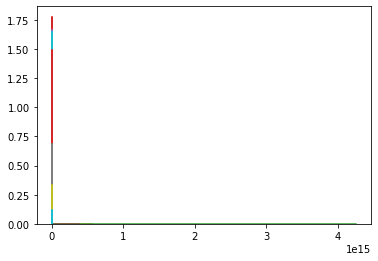

In [9]:
scaler = RobustScaler()
X_sub1 = scaler.fit_transform(X_processed_sub1) # this normalizes well
X_sub2 = scaler.fit_transform(X_processed_sub2) # this normalizes well

print(X_sub1.shape[1])
for i in range(X_sub1.shape[1]):
    sns.kdeplot(X_sub1[:,i])
    
print(X_sub2.shape[1])
for i in range(X_sub2.shape[1]):
    sns.kdeplot(X_sub2[:,i])

Finding the most important features

## Setting up the variables to run the classifier

In [10]:
clf_1 = RandomForestClassifier(n_estimators=100)
clf_2 = RandomForestClassifier(n_estimators=100)

## Cross-validation

In [11]:
scores_1 = []
scores_2 = []

if windowing:
    cv = GroupKFold(n_splits=10)
else:
    cv = KFold(n_splits=10, random_state=42, shuffle=True)


## Calculate model accuracy

In [12]:
# training on 1, testing on 2
if windowing:
    for train_index, test_index in cv.split(X_sub1, Y_adjusted_sub1, groups_1):
        X_train, X_test, y_train, y_test = X_sub1[train_index], X_sub1[test_index], Y_adjusted_sub1[train_index], Y_adjusted_sub1[test_index]
        clf_1.fit(X_train, y_train)
        scores_1.append(clf_1.score(X_test, y_test))
else:
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X_sub1[train_index], X_sub1[test_index], Y_adjusted_sub1[train_index], Y_adjusted_sub1[test_index]
        clf_1.fit(X_train, y_train)
        scores_1.append(clf_1.score(X_test, y_test))
        
        
# training on 2, testing on 1      
if windowing:
    for train_index, test_index in cv.split(X_sub2, Y_adjusted_sub2, groups_2):
        X_train, X_test, y_train, y_test = X_sub2[train_index], X_sub2[test_index], Y_adjusted_sub2[train_index], Y_adjusted_sub2[test_index]
        clf_2.fit(X_train, y_train)
        scores_2.append(clf_2.score(X_test, y_test))
else:
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X_sub2[train_index], X_sub2[test_index], Y_adjusted_sub2[train_index], Y_adjusted_sub2[test_index]
        clf_2.fit(X_train, y_train)
        scores_2.append(clf_2.score(X_test, y_test))
 
print("Mean accuracy testing on self, subject 1: " + str(np.mean(scores_1)))
print("Mean accuracy testing on self, subject 2: " + str(np.mean(scores_2)))
print("")

# testing subject 2 on subject 1 model
print("Testing subject 2 on subject 1 model:")
print("Mean accuracy: " + str(clf_1.score(X_sub2, Y_adjusted_sub2)))
print("")

# testing subject 1 on subject 2 model
print("Testing subject 1 on subject 2 model:")
print("Mean accuracy: " + str(clf_2.score(X_sub1, Y_adjusted_sub1)))

Mean accuracy testing on self, subject 1: 0.9488245903946184
Mean accuracy testing on self, subject 2: 0.9790909233874421

Testing subject 2 on subject 1 model:
Mean accuracy: 0.12400983337885824

Testing subject 1 on subject 2 model:
Mean accuracy: 0.07106899615042937


## Confusion matrix

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
#     return ax

np.set_printoptions(precision=2)

In [14]:
true_y_sub1 = []
pred_y_sub1 = []

if windowing:
    for train_index, test_index in cv.split(X_sub1, Y_adjusted_sub1, groups_1):
        X_train, X_test, y_train, y_test = X_sub1[train_index], X_sub1[test_index], Y_adjusted_sub1[train_index], Y_adjusted_sub1[test_index]
        
        # get predictions
        predictions = clf_1.fit(X_train, y_train).predict(X_test)
        pred_y_sub1.extend(predictions)
        true_y_sub1.extend(y_test)
else:
    for train_index, test_index in cv.split(X_sub1):
        X_train, X_test, y_train, y_test = X_sub1[train_index], X_sub1[test_index], Y_adjusted_sub1[train_index], Y_adjusted_sub1[test_index]
        
        # get predictions
        predictions = clf_1.fit(X_train, y_train).predict(X_test)
        pred_y_sub1.extend(predictions)
        true_y_sub1.extend(y_test)

true_y_sub2 = []
pred_y_sub2 = []
if windowing:
    for train_index, test_index in cv.split(X_sub2, Y_adjusted_sub2, groups_2):
        X_train, X_test, y_train, y_test = X_sub2[train_index], X_sub2[test_index], Y_adjusted_sub2[train_index], Y_adjusted_sub2[test_index]
        
        # get predictions
        predictions = clf_2.fit(X_train, y_train).predict(X_test)
        pred_y_sub2.extend(predictions)
        true_y_sub2.extend(y_test)
else:
    for train_index, test_index in cv.split(X_sub2):
        X_train, X_test, y_train, y_test = X_sub2[train_index], X_sub2[test_index], Y_adjusted_sub2[train_index], Y_adjusted_sub2[test_index]
        
        # get predictions
        predictions = clf_2.fit(X_train, y_train).predict(X_test)
        pred_y_sub2.extend(predictions)
        true_y_sub2.extend(y_test)

Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   0.89 0.   0.   0.11]
 [0.   0.   1.   0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.14 0.   0.   0.86]]


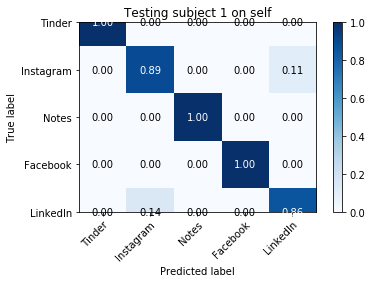

Normalized confusion matrix
[[1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.01 0.92 0.02 0.06]
 [0.   0.   0.01 0.99 0.  ]
 [0.   0.01 0.   0.   0.99]]


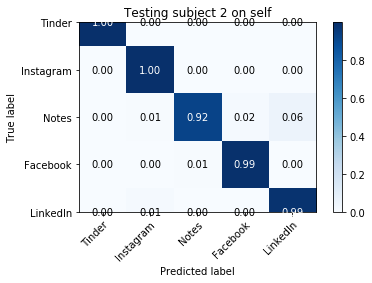

Normalized confusion matrix
[[0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00]
 [2.15e-01 0.00e+00 7.79e-02 7.07e-01 0.00e+00]
 [5.76e-04 3.75e-01 2.28e-01 0.00e+00 3.97e-01]
 [0.00e+00 2.91e-01 5.27e-01 1.81e-01 1.51e-03]
 [7.51e-01 0.00e+00 0.00e+00 2.49e-01 0.00e+00]]


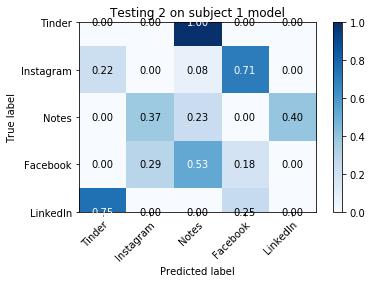

Normalized confusion matrix
[[0.   0.43 0.   0.   0.57]
 [0.   0.   1.   0.   0.  ]
 [0.33 0.07 0.12 0.39 0.09]
 [0.02 0.31 0.38 0.   0.3 ]
 [0.   0.53 0.47 0.   0.  ]]


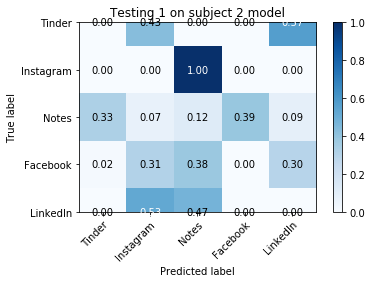

In [15]:
# true y vs predicted y
class_names = np.asarray(["Tinder", "Instagram", "Notes", "Facebook", "LinkedIn"])
plot_confusion_matrix(true_y_sub1, pred_y_sub1, classes=class_names, normalize=True,
                      title='Testing subject 1 on self')

plot_confusion_matrix(true_y_sub2, pred_y_sub2, classes=class_names, normalize=True,
                      title='Testing subject 2 on self')

# testing on each other
pred_res1 = clf_1.predict(X_sub2)
plot_confusion_matrix(pred_res1, Y_adjusted_sub2, classes=class_names, normalize=True,
                      title='Testing 2 on subject 1 model')

pred_res2 = clf_2.predict(X_sub1)
plot_confusion_matrix(pred_res2, Y_adjusted_sub1, classes=class_names, normalize=True,
                      title='Testing 1 on subject 2 model')